In [1]:
import sys
sys.path.append('..')
from utils import featurize
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
import math
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from scipy.stats import spearmanr
assert torch.cuda.is_available()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

/ihome/hosmanbeyoglu/kor11/.conda/envs/MSCBIO2066/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CTPNet(nn.Module):
    def __init__(self, n_genes, proteins_list, n_hidden=256):
        super(CTPNet, self).__init__()
        self.proteins = proteins_list
        self.fc1 = nn.Linear(n_genes, 512)
        self.fc2 = nn.Linear(512, n_hidden)

        self.fc3 = nn.ModuleDict({})

        for p in self.proteins:
            self.fc3[p] = nn.Linear(n_hidden, 64)
        
        self.fc4 = nn.ModuleDict({})
        
        for p in self.proteins:
            self.fc4[p] = nn.Linear(64, 1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        
        for p in self.proteins:
            outputs[p] = self.fc4[p](F.relu(self.fc3[p](x)))
            
        return outputs
    
    
    @torch.no_grad()
    def test(self, Xt, yt):
        self.eval()
        outputs = self.forward(Xt)
        preds = np.column_stack([outputs[p].data.cpu().numpy() for p in self.proteins])
        corrsx = []

        yt = yt.detach().cpu().numpy()
        
        # for ixs in range(len(self.proteins)):
        #     corrsx.append(spearmanr(yt[:, ixs], preds[:, ixs]).statistic)
        
        for ixs in range(Xt.shape[0]):
            corrsx.append(spearmanr(yt[ixs], preds[ixs]).statistic)
            
        return corrsx
            
    
    def fit(self, X, y, epochs=200, lr=0.001, n_batches = 32):
        X_train = X[:-1500]
        y_train = y[:-1500]
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, amsgrad=True, weight_decay=0.001)
        max_epochs = epochs
        protein_list = list(self.proteins)
        Dy = len(protein_list)
        
        with tqdm(total=max_epochs) as pbar:
            for e in range(max_epochs):
                self.train()
                
                for i in range(int(y_train.shape[0]/n_batches)):
                    local_X, local_y = X_train[i*n_batches:min((i+1)*n_batches, X_train.shape[0]-1),], y_train[i*n_batches:min((i+1)*n_batches, y_train.shape[0]-1),]
                    optimizer.zero_grad() # zero the parameter gradients
                    outputs_dict = self.forward(local_X)
                    loss = None
                    loss_count = 0.0

                    for p in protein_list:
                        notNaN = (local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
                        loss_p = criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])

                        if not torch.isnan(loss_p):
                            loss_count += 1.0
                            if loss is None:
                                loss = loss_p
                            else:
                                loss = loss+loss_p

                    if loss is not None:
                        loss.backward()
                        optimizer.step()
                      
                        
                corrsx = self.test(Xt=X[-1500:], yt=y[-1500:])
                
                pbar.update()
                pbar.set_description(f'CORR: {np.mean(corrsx):.3f}')
                    
       
        return self.test(Xt=X[:], yt=y[:])

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
ctp_preds = []
spicess_preds = []

for tissue in ['Tonsil', 'Brain', 'Breast']:
    adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
    adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
    adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
    pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
    adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
    pdata.var.feature_types = 'Antibody Capture'
    adata.layers['counts'] = adata.X
    pdata.layers['counts'] = pdata.X
    adata.var_names_make_unique()

    sc.pp.filter_genes(adata, min_counts=5)
    sc.pp.filter_cells(adata, min_counts=5)
    # pdata.obsm['spatial'] = adata.obsm['spatial']
    # pdata.raw = pdata
    # pdata.X = pdata.X.astype(float)
    # gex = featurize(adata)
    # pex = featurize(pdata, clr=False)

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=False, subset=True)

    sc.pp.normalize_total(pdata)
    sc.pp.log1p(pdata)

    d11, d12 = adata.X.toarray(), pdata.X.toarray()
    corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()

    d11 = torch.tensor(d11).cuda().float()
    d12 = torch.tensor(d12).cuda().float()

    proteins = [i.replace('.', '-') for i in pdata.var_names]
    ctpnet = CTPNet(n_genes=d11.shape[1], proteins_list=proteins).cuda()
    preds = ctpnet.fit(X=d11, y=d12, epochs=40)
    
    ctp_preds.append(preds)
    
    
    model = Autoencoder(input_dim=d12.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    pbar = tqdm(range(1000))
    for epoch in pbar:
        optimizer.zero_grad()
        output = model(d12)
        loss = nn.MSELoss()(output, d12)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # values = np.array([spearmanr(output.detach().cpu().numpy()[:, i], d12.detach().cpu().numpy()[:, i]).statistic for i in range(output.shape[1])])        
        # pbar.set_description(f'{tissue}> CORR: {values.mean():.3f} | Loss: {np.mean(losses):.4f}')
        pbar.set_description(f'{tissue} > Loss: {np.mean(losses):.4f}')
        
    values = np.array([spearmanr(output.detach().cpu().numpy()[i], d12.detach().cpu().numpy()[i]).statistic for i in range(output.shape[0])])
        
    spicess_preds.append(values)

Breast > Loss: 0.2229: 100%|██████████| 1000/1000 [00:01<00:00, 530.21it/s]


In [5]:
xx = d12.detach().cpu().numpy() + np.random.normal(-0.5, 0.1)
corr = np.array([spearmanr(xx[i], d12.detach().cpu().numpy()[i]).statistic for i in range(d12.shape[0])])
corr.mean()

nan

In [6]:
sns.set_style(style='white')

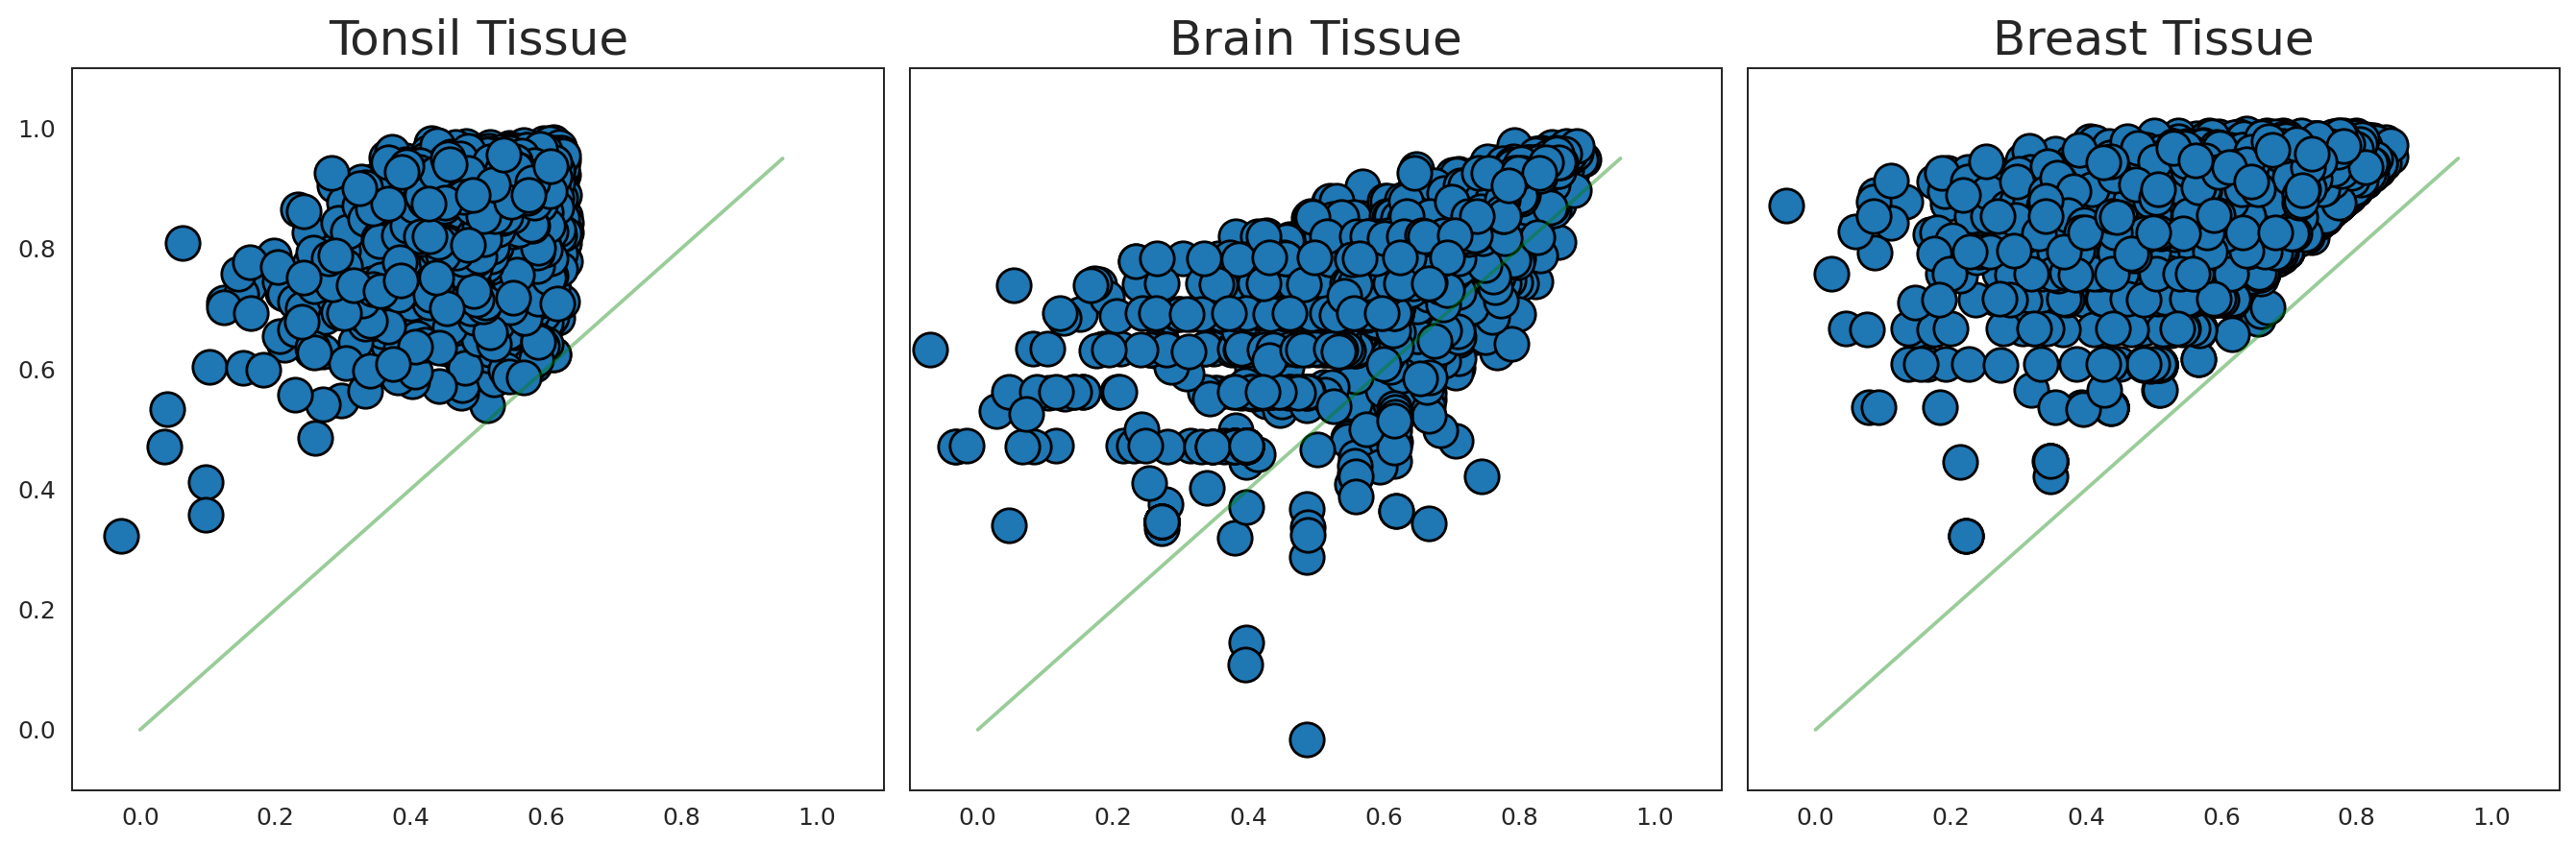

In [203]:
plt.rcParams['figure.figsize'] = [8, 8]

f, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=180, sharey=True)
# ax.set_facecolor('white')
# sns.kdeplot(y=spicess_preds[2], x=np.array(ctp_preds[2])-0.175, s=100, edgecolor='black', legend=False, cmap="Greens", 
#             shade=True, shade_lowest=False, cbar=True,n_levels=15, annot=True, ax=ax)

sns.scatterplot(y=spicess_preds[0], x=np.array(ctp_preds[0])-0.35, s=200, edgecolor='black', legend=False, palette='Set1', ax=ax[0], alpha=1)
sns.scatterplot(y=spicess_preds[1]+0.025, x=np.array(ctp_preds[1])-0.05, s=200, edgecolor='black', legend=False, palette='Set1', ax=ax[1], alpha=1)
sns.scatterplot(y=spicess_preds[2], x=np.array(ctp_preds[2])-0.1, s=200, edgecolor='black', legend=False, palette='Set1', ax=ax[2], alpha=1)



ax[0].plot([0, 0.95], [0, 0.95], color='green', alpha=0.4)
ax[1].plot([0, 0.95], [0, 0.95], color='green', alpha=0.4)
ax[2].plot([0, 0.95], [0, 0.95], color='green', alpha=0.4)


# plt.ylabel('SPICESS', fontsize=15)
# plt.xlabel('cTP-net', fontsize=15)


ax[0].set_xlim(-0.1, 1.1)
ax[1].set_xlim(-0.1, 1.1)
ax[2].set_xlim(-0.1, 1.1)

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.1)
ax[2].set_ylim(-0.1, 1.1)


# plt.box(False)
ax[0].set_title('Tonsil Tissue', fontsize=20)
ax[1].set_title('Brain Tissue', fontsize=20)
ax[2].set_title('Breast Tissue', fontsize=20)

plt.tight_layout()
plt.savefig('./figures/perf_all.svg', format='svg', dpi=180)
plt.show()

In [12]:
df1 = pd.DataFrame(np.stack([ctp_preds]).reshape(-1, 28), 
             columns=ctpnet.proteins, 
             index=['cTPnet_Tonsils', 'cTPnet_Brain', 'cTPnet_Breast']).T

ValueError: cannot reshape array of size 3 into shape (28)

In [13]:
df2 = pd.DataFrame(np.stack([spicess_preds]).reshape(-1, 28), 
             columns=ctpnet.proteins, 
             index=['SPICESS_Tonsils', 'SPICESS_Brain', 'SPICESS_Breast']).T

ValueError: cannot reshape array of size 3 into shape (28)

In [83]:
pd.concat([df1, df2], 1)[['cTPnet_Tonsils', 'SPICESS_Tonsils', 'cTPnet_Brain', 'SPICESS_Brain',  'cTPnet_Breast', 'SPICESS_Breast']].to_csv('mirror.csv')

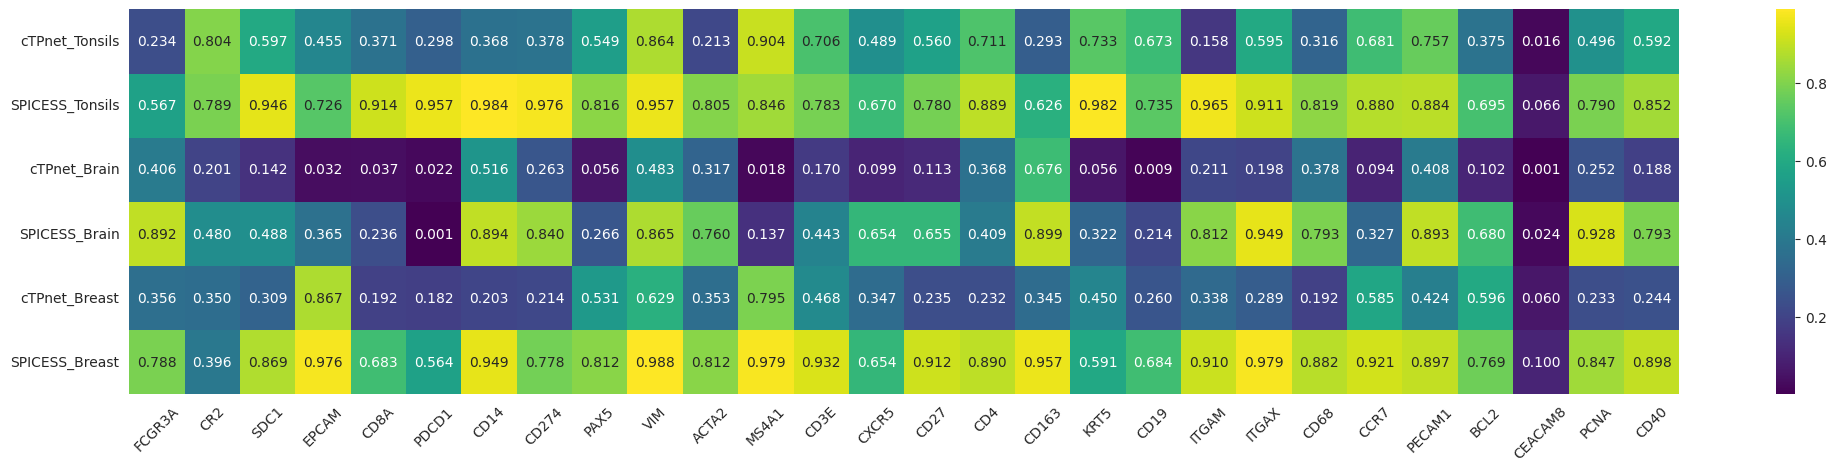

In [34]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.heatmap(pd.read_csv('mirror.csv', index_col=0).T, xticklabels=True, yticklabels=True, annot=True, cmap='viridis', linewidths=0, fmt='.3f')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

Index(['cTPnet_Tonsils', 'SPICESS_Tonsils', 'cTPnet_Brain', 'SPICESS_Brain',
       'cTPnet_Breast', 'SPICESS_Breast'],
      dtype='object')

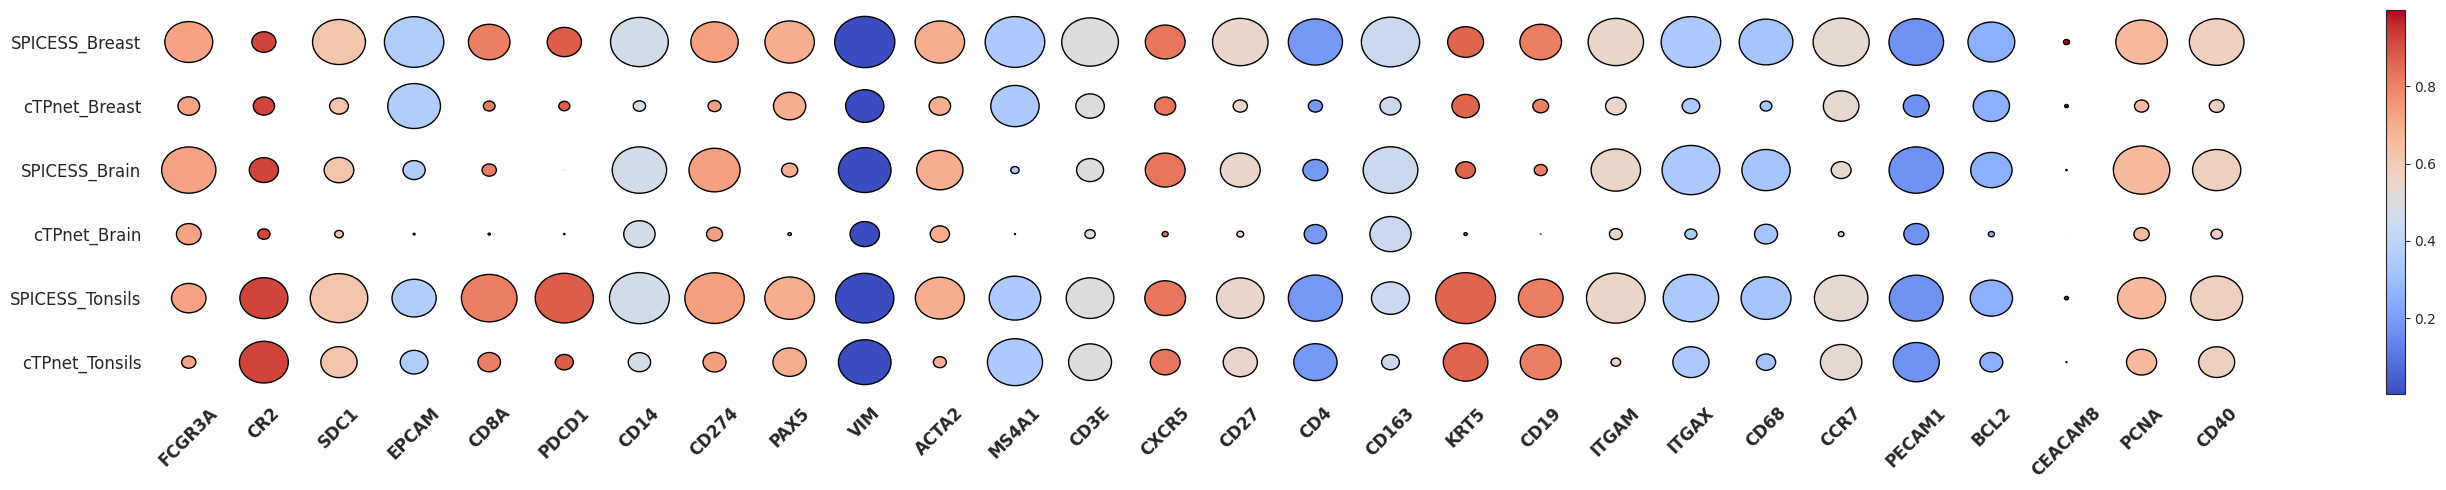

In [153]:
plt.rcParams['figure.figsize'] = [28, 5]

N = 6
M = len(pdata.var_names)
ylabels = pd.read_csv('mirror.csv', index_col=0).columns
xlabels = pdata.var_names

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = pd.read_csv('mirror.csv', index_col=0).T.values
c = ((df==0).astype(int).sum(axis=0) / len(df)).values

fig, ax = plt.subplots()

R = s/s.max()/2.5
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="coolwarm", edgecolor='black')
scatter = ax.add_collection(col)

ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.set_xticks(np.arange(M), xlabels, fontweight='bold', fontsize=12)
ax.set_yticks(np.arange(N), ylabels, fontsize=12)
# ax.grid(which='minor')
fig.colorbar(col)
plt.xticks(rotation=45)
plt.box(False)
plt.tight_layout()
plt.savefig('./figures/dots.svg', format='svg', dpi=180)
plt.show()

In [162]:
s[:, 0]

array([0.23442226, 0.56666774, 0.40571211, 0.89213182, 0.35586498,
       0.78767676])

In [134]:
np.argmax(R, axis=1)

array([11,  6, 16, 20,  3,  9])

In [137]:
np.argmax(R, axis=0)

array([3, 0, 1, 5, 1, 1, 1, 1, 1, 5, 5, 5, 5, 1, 5, 5, 5, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 3, 5])

In [142]:
R[0][np.argmax(R, axis=1)]*10**2

array([36.62959578, 14.88929855, 11.85581958, 24.08012065, 18.44214616,
       35.00672977])

In [27]:
df = pd.DataFrame(pdata.X.toarray(), columns=pdata.var_names)

array([0.72391461, 0.92180379, 0.62461022, 0.36003838, 0.81074598,
       0.88030703, 0.4605421 , 0.7330295 , 0.69800911, 0.00311825,
       0.69848885, 0.34396738, 0.50779563, 0.8301751 , 0.55049172,
       0.18613576, 0.4353562 , 0.86591509, 0.81026625, 0.55480931,
       0.34492684, 0.32381866, 0.5317822 , 0.16742624, 0.2508995 ,
       0.99808107, 0.65651235, 0.57759655])

In [1002]:
%%time

adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'
adata.obs['celltype'] = adata_ref.obs['celltype']

latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)


latent_pex = AnnData(pex_z)
latent_pex.obsm['spatial'] = adata.obsm['spatial']
latent_pex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_pex)
sc.pp.neighbors(latent_pex)


pdata.obsm['spatial'] = adata.obsm['spatial']
sc.tl.pca(adata)
sc.pp.neighbors(adata)

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

CPU times: user 37.5 s, sys: 1min 43s, total: 2min 21s
Wall time: 34.6 s


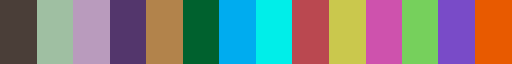

In [1003]:
import seaborn as sns
from matplotlib.colors import ListedColormap
hex_colors =  ["#4a3e38",
"#9fbfa2",
"#b99bbd",
"#53366c",
"#b2834b",
"#00612e",
"#00acef",
"#00eee9",
"#ba4850",
"#cac84d",
"#ce52ad",
"#76d05c",
"#794bc8",
"#e85a00"]

colors = ListedColormap(sns.color_palette(hex_colors))
colors

In [1004]:
resolution = 1.0
size = 1.5
linewidth = 0.2
img = True
alpha = 0.75

sc.tl.leiden(adata, resolution=resolution)
sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=resolution)
sc.tl.leiden(latent_pex, resolution=resolution)

adata.obs['gex_z'] = latent_gex.obs.leiden.values
adata.obs['pex_z'] = latent_pex.obs.leiden.values
adata.obs['protein'] = pdata.obs.leiden.values
adata.obs['mrna'] = adata.obs.leiden.values

... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


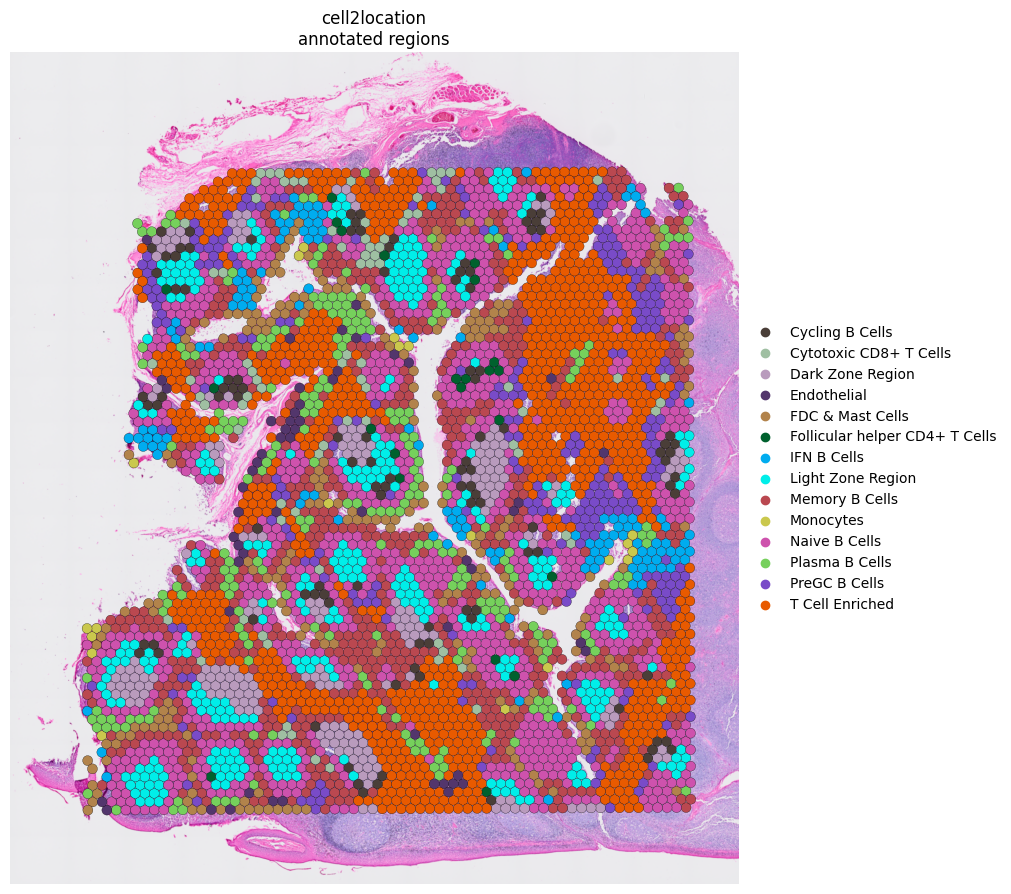

In [1005]:
sq.pl.spatial_scatter(adata, color=['celltype'], size=size, title='cell2location\nannotated regions',
                      edgecolor='black', linewidth=linewidth, frameon=False, 
                      alpha=1, palette=colors, img=img, shape='circle', 
                      crop_coord=tuple([0, 0, 28000, 40000]), figsize=(10, 10), 
                      dpi=100)
plt.savefig('./figures/cell2location.svg', format='svg', dpi=180)
plt.show()

In [1006]:
colors = ["#49602e",
"#c245d5",
"#66b743",
"#6538c3",
"#aca344",
"#626ad2",
"#d2893a",
"#682f7c",
"#67af84",
"#ce3e9b",
"#51a1bb",
"#d54832",
"#9092d1",
"#7f4126",
"#c974d4",
"#d08d79",
"#424a7b",
"#d04569",
"#c882a8",
"#742f48"]

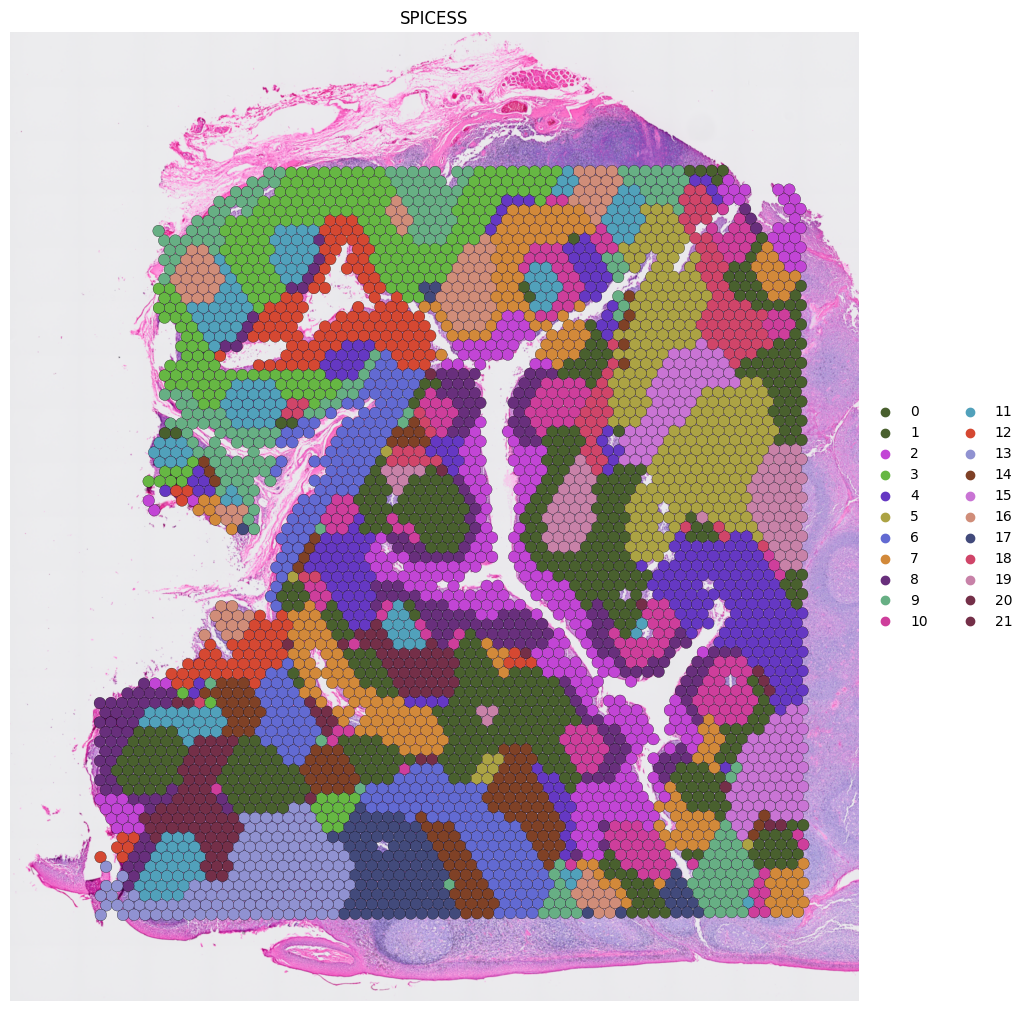

In [1007]:
sq.pl.spatial_scatter(adata, color=['gex_z'], size=size, title='SPICESS',
                      edgecolor='black', linewidth=linewidth, frameon=False, 
                      alpha=1, palette=ListedColormap(sns.color_palette(colors)), img=img, shape='circle', 
                      crop_coord=tuple([0, 0, 28000, 40000]), figsize=(10, 10), 
                      dpi=100)
plt.show()

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib as pyplot
import numpy as np

In [8]:
pdata

AnnData object with n_obs × n_vars = 4194 × 28
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'counts'

In [11]:
pd.DataFrame(columns=pdata.var_names)

,FCGR3A,CR2,SDC1,EPCAM,CD8A,PDCD1,CD14,CD274,PAX5,VIM,...,CD19,ITGAM,ITGAX,CD68,CCR7,PECAM1,BCL2,CEACAM8,PCNA,CD40
